In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, ZeroPadding2D, Dense, AvgPool2D,GlobalAveragePooling2D, MaxPool2D, BatchNormalization, Add, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, ReLU, concatenate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model


# CIFAR
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

print(training_images.shape)
print(training_labels.shape)
print(validation_images.shape)
print(validation_labels.shape)

print(validation_labels[0])

print("################")

# Przekształcenie etykiet na takie, które będą pasowały do modelu
training_labels = to_categorical(training_labels, 10)
validation_labels = to_categorical(validation_labels, 10)

print(training_images.shape)
print(training_labels.shape)
print(validation_images.shape)
print(validation_labels.shape)

print(validation_labels[0])


(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
[3]
################
(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


Implamentacja densenet https://arxiv.org/pdf/1608.06993.pdf

In [11]:
## DenseNet-121
# 
input_shape = 32, 32, 3
n_classes = 10
filters = 32 # growth_rate
## repetitions in dense block 
densenet121_repetition = [6, 12, 24, 16] # <- values for DenseNet-121

#batch norm + relu + conv
def bn_relu_conv(x,filters,kernel=1,strides=1):
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(filters, kernel, strides=strides, padding='same')(x)
  return x

# dense block
def dense_block(x, repetition):
  for _ in range(repetition):
    y = bn_relu_conv(x, 4* filters) # The number 4 is given by the authors in the paper
    y = bn_relu_conv(y, filters, 3)
    x = concatenate([y, x])
  return x

def transition_layer(x):
  x = bn_relu_conv(x, K.int_shape(x)[-1] //2 ) # reducing in half the number of feature maps
  x = AvgPool2D(2, strides = 2, padding = 'same')(x)
  return x

input = Input(input_shape)
x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
x = MaxPool2D(3, strides = 2, padding = 'same')(x)

for repetition in densenet121_repetition:
        
    d = dense_block(x, repetition)
    x = transition_layer(d)

x = GlobalAveragePooling2D()(d)
output = Dense(n_classes, activation = 'softmax')(x)
model = Model(input, output)
    

model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_121 (Conv2D)            (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 64)    0           ['conv2d_121[0][0]']             
                                                                                                  
 batch_normalization_120 (Batch  (None, 8, 8, 64)    256         ['max_pooling2d_1[0][0]']        
 Normalization)                                                                             

In [12]:
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.7),
    metrics=['accuracy']
)

history = model.fit(
    x=training_images,
    y=training_labels,
    batch_size=512,
    epochs=10,
    validation_data=(validation_images, validation_labels)
)


Epoch 1/10
98/98 [==============================] - 54s 411ms/step - loss: 1.7740 - accuracy: 0.3500 - val_loss: 2.1407 - val_accuracy: 0.2319
Epoch 2/10
98/98 [==============================] - 36s 368ms/step - loss: 1.4066 - accuracy: 0.4850 - val_loss: 1.8640 - val_accuracy: 0.3455
Epoch 3/10
98/98 [==============================] - 36s 368ms/step - loss: 1.2546 - accuracy: 0.5461 - val_loss: 1.6205 - val_accuracy: 0.4094
Epoch 4/10
98/98 [==============================] - 36s 369ms/step - loss: 1.1336 - accuracy: 0.5943 - val_loss: 1.3691 - val_accuracy: 0.5064
Epoch 5/10
98/98 [==============================] - 36s 369ms/step - loss: 1.0311 - accuracy: 0.6312 - val_loss: 1.3689 - val_accuracy: 0.5332
Epoch 6/10
98/98 [==============================] - 36s 368ms/step - loss: 0.9445 - accuracy: 0.6640 - val_loss: 1.2574 - val_accuracy: 0.5542
Epoch 7/10
98/98 [==============================] - 36s 368ms/step - loss: 0.8558 - accuracy: 0.6980 - val_loss: 1.4442 - val_accuracy: 0.5132

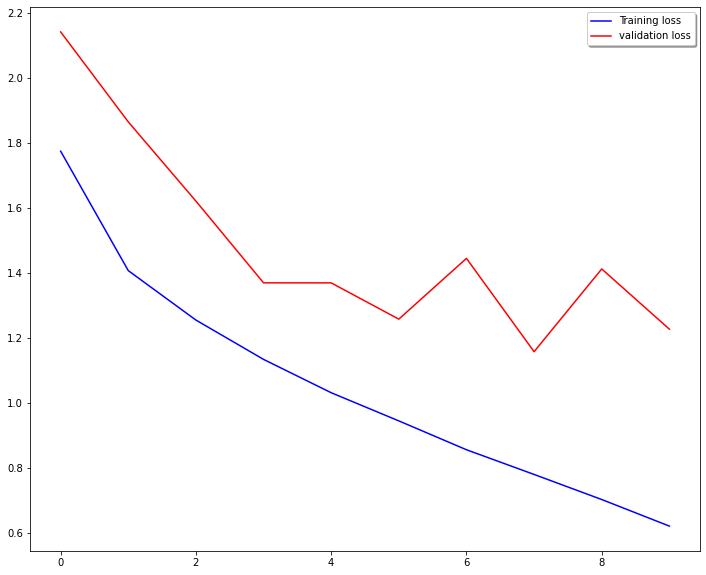

In [13]:
import matplotlib.pyplot as plt

fig = plt.subplots(figsize=(12,10))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.legend(loc='best', shadow=True)
